In [47]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

In [3]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [4]:

status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [5]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [6]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [7]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [8]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

In [11]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


What are the categorical variables? What are the numerical?

In [12]:
numerical = [
    'seniority', 'time', 'age', 'expenses', 
    'income', 'assets', 'debt', 'amount', 'price'
]

categorical = [
    'home', 'marital', 'records', 'job'
]

In [40]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

#### Question 1

In [29]:
for num in numerical:
    fpr, tpr, thresholds = roc_curve(df_train.default.values, df_train[num].values)
    auc_score = auc(fpr, tpr)
    if auc_score < 0.5:
        fpr, tpr, thresholds = roc_curve(df_train.default.values, -df_train[num].values)
        auc_score = auc(fpr, tpr)
    print(f'Feature {num} auc score {auc_score}')

Feature seniority auc score 0.7093778624491943
Feature time auc score 0.5608662489595051
Feature age auc score 0.5732933272499939
Feature expenses auc score 0.5009184217217011
Feature income auc score 0.682006666132633
Feature assets auc score 0.6486042567122802
Feature debt auc score 0.5047829675783548
Feature amount auc score 0.5910773431595518
Feature price auc score 0.5043329862114843


Seniority

In [41]:
df_train = df_train[['seniority', 'income', 'assets', 'records', 'job', 'home', 'default']].reset_index(drop=True)
df_val = df_val[['seniority', 'income', 'assets', 'records', 'job', 'home', 'default']].reset_index(drop=True)
df_test = df_test[['seniority', 'income', 'assets', 'records', 'job', 'home', 'default']].reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

In [44]:
dv = DictVectorizer(sparse=False)
train_dicts = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

In [49]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

#### Question 2

In [50]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [52]:
y_pred = model.predict_proba(X_val)[:, 1]

In [54]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc_score = round(auc(fpr, tpr), 3)
auc_score

0.812

#### Question 3

In [55]:
thresholds = np.linspace(0, 1, 101)

In [57]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (actual_negative & predict_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    scores.append((t, tp, fp, fn, tn, precision, recall))

/Users/zorikhin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in long_scalars


In [59]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']
df_scores = pd.DataFrame(scores, columns=columns)

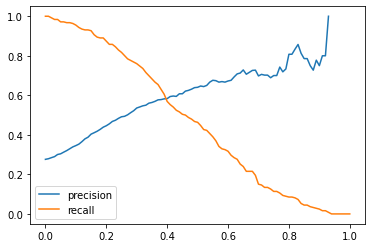

In [62]:
plt.plot(df_scores.threshold, df_scores['precision'], label='precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='recall')
plt.legend()

0.4